# Load Graph

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Nodes   500 non-null    int64
 1   Labels  500 non-null    int64
dtypes: int64(2)
memory usage: 7.9 KB


<ipython-input-2-f845f17e8798>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap("viridis", len(unique_labels))  # Choose colormap
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


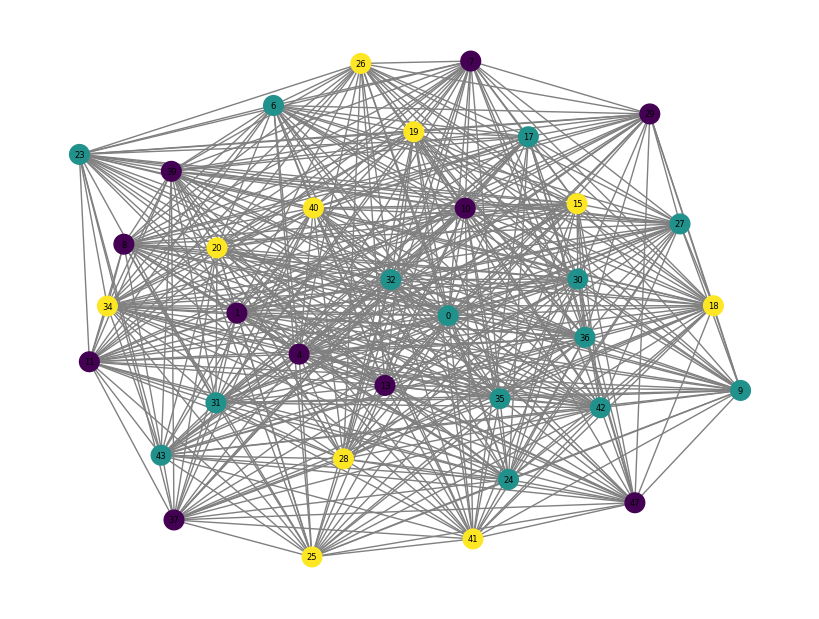

In [2]:


import networkx as nx
import matplotlib.pyplot as plt

import pandas as pd
df = pd.read_csv('/kaggle/input/bdbnwk10/labels.csv')
df.info()

# Load the graph from an edgelist file
G = nx.read_edgelist("/kaggle/input/bdbnwk10/graph.edgelist",nodetype=int)

# Take a subgraph with the first 50 nodes
sub_nodes = list(G.nodes())[:35]
G_sub = G.subgraph(sub_nodes)

# Create a color map based on labels
label_dict = dict(zip(df["Nodes"], df["Labels"]))  # Map nodes to labels
colors = [label_dict.get(node, 0) for node in G_sub.nodes()]  # Default to 0 if missing

# Normalize colors (if needed)
unique_labels = list(set(label_dict.values()))
color_map = plt.cm.get_cmap("viridis", len(unique_labels))  # Choose colormap
node_colors = [color_map(unique_labels.index(label)) for label in colors]

# Draw the subgraph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_sub)  # Layout
nx.draw(G_sub, pos, with_labels=True, node_color=node_colors, edge_color="gray",
        node_size=200, font_size=6, cmap=color_map)

plt.show()

In [1]:
!pip install node2vec

In [2]:
import numpy as np
from node2vec import Node2Vec
print(np.__version__)
print(Node2Vec)


1.26.4
<class 'node2vec.node2vec.Node2Vec'>


# Node2Vec

Testing p=0.25, q=0.25
Testing p=0.25, q=1.5
Testing p=0.25, q=2.75
Testing p=0.25, q=4.0
Testing p=1.5, q=0.25
Testing p=1.5, q=1.5
Testing p=1.5, q=2.75
Testing p=1.5, q=4.0
Testing p=2.75, q=0.25
Testing p=2.75, q=1.5
Testing p=2.75, q=2.75
Testing p=2.75, q=4.0
Testing p=4.0, q=0.25
Testing p=4.0, q=1.5
Testing p=4.0, q=2.75
Testing p=4.0, q=4.0


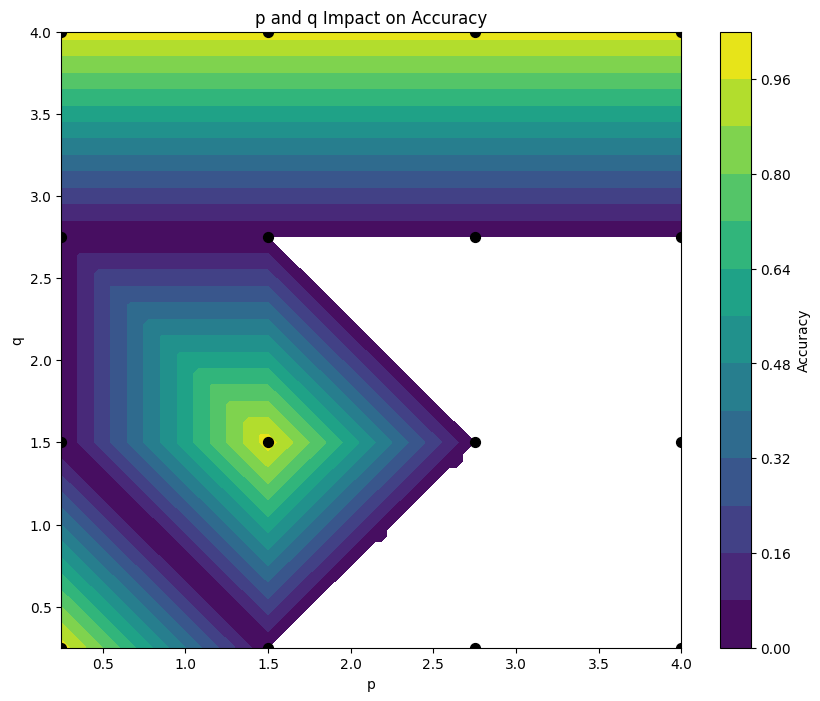

Testing Walk Length=2.0, Num Walks=2.0
Testing Walk Length=2.0, Num Walks=4.666666666666666
Testing Walk Length=2.0, Num Walks=7.333333333333333
Testing Walk Length=2.0, Num Walks=10.0
Testing Walk Length=4.666666666666666, Num Walks=2.0
Testing Walk Length=4.666666666666666, Num Walks=4.666666666666666
Testing Walk Length=4.666666666666666, Num Walks=7.333333333333333
Testing Walk Length=4.666666666666666, Num Walks=10.0
Testing Walk Length=7.333333333333333, Num Walks=2.0
Testing Walk Length=7.333333333333333, Num Walks=4.666666666666666
Testing Walk Length=7.333333333333333, Num Walks=7.333333333333333
Testing Walk Length=7.333333333333333, Num Walks=10.0
Testing Walk Length=10.0, Num Walks=2.0
Testing Walk Length=10.0, Num Walks=4.666666666666666
Testing Walk Length=10.0, Num Walks=7.333333333333333
Testing Walk Length=10.0, Num Walks=10.0


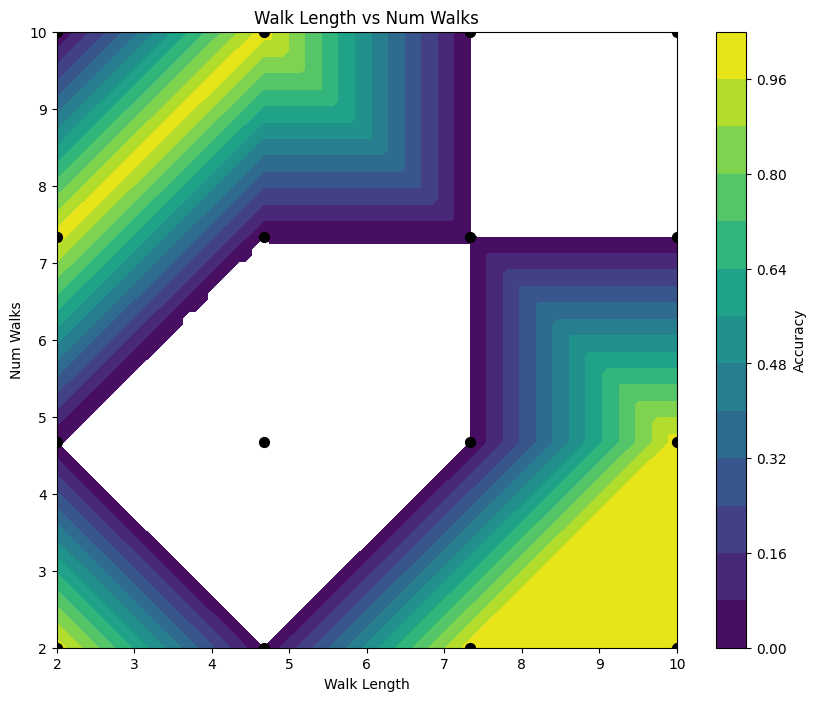

Testing Embedding Size=4.0, Window Size=2.0
Testing Embedding Size=4.0, Window Size=4.666666666666666
Testing Embedding Size=4.0, Window Size=7.333333333333333
Testing Embedding Size=4.0, Window Size=10.0
Testing Embedding Size=13.333333333333334, Window Size=2.0
Testing Embedding Size=13.333333333333334, Window Size=4.666666666666666
Testing Embedding Size=13.333333333333334, Window Size=7.333333333333333
Testing Embedding Size=13.333333333333334, Window Size=10.0
Testing Embedding Size=22.666666666666668, Window Size=2.0
Testing Embedding Size=22.666666666666668, Window Size=4.666666666666666
Testing Embedding Size=22.666666666666668, Window Size=7.333333333333333
Testing Embedding Size=22.666666666666668, Window Size=10.0
Testing Embedding Size=32.0, Window Size=2.0
Testing Embedding Size=32.0, Window Size=4.666666666666666
Testing Embedding Size=32.0, Window Size=7.333333333333333
Testing Embedding Size=32.0, Window Size=10.0


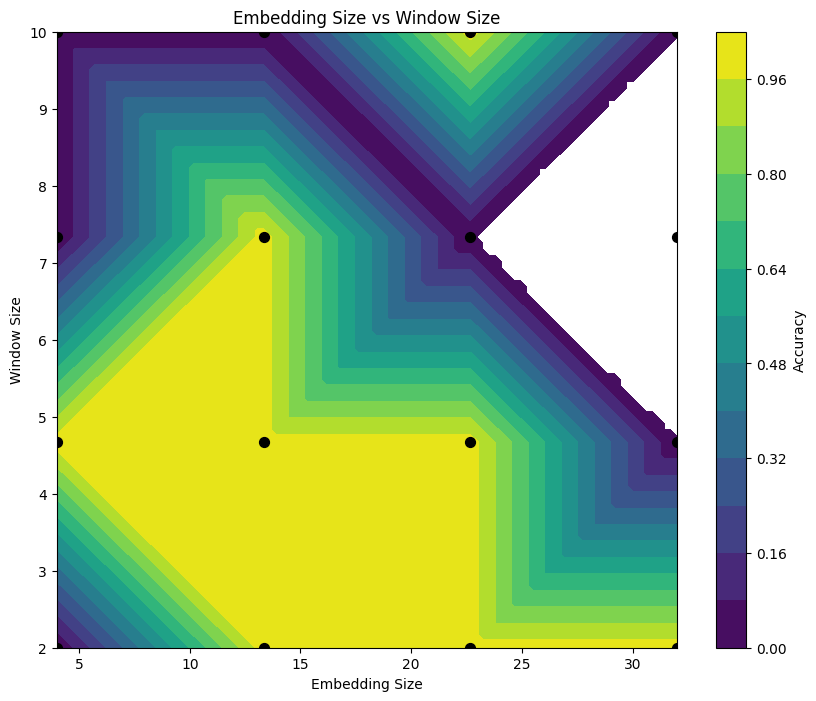

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from node2vec import Node2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.interpolate import griddata
import time
import signal
import warnings
warnings.filterwarnings('ignore')

# Timeout handler
class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException("Function timed out")

# Load data
df = pd.read_csv('/kaggle/input/bdbnwk10/labels.csv')
G = nx.read_edgelist("/kaggle/input/bdbnwk10/graph.edgelist", nodetype=int).to_undirected()

# Use a small subgraph
sub_nodes = list(G.nodes())[:5]  # Only 5 nodes for quick testing
G = G.subgraph(sub_nodes)

# Prepare labels
label_dict = dict(zip(df["Nodes"], df["Labels"]))
nodes = list(G.nodes())
labels = np.array([label_dict.get(node, 0) for node in nodes])

def evaluate_params(param1, param2, param_type, max_time=10):
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(max_time)
    
    try:
        if param_type == "p_q":
            node2vec = Node2Vec(G, dimensions=8, walk_length=3, num_walks=3, p=param1, q=param2, workers=1,quiet=True)
        elif param_type == "walk_length_num_walks":
            node2vec = Node2Vec(G, dimensions=8, walk_length=int(param1), num_walks=int(param2), p=1, q=1, workers=1,quiet=True)
        elif param_type == "embedding_window":
            node2vec = Node2Vec(G, dimensions=int(param1), walk_length=3, num_walks=3, p=1, q=1, workers=1,quiet=True)
        
        model = node2vec.fit(window=2, min_count=1, batch_words=4, epochs=1)
        embeddings = np.array([model.wv[str(node)] for node in nodes])
        
        X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)
        clf = LogisticRegression(max_iter=100)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        signal.alarm(0)
        return accuracy_score(y_test, y_pred)
    except:
        return 0.5  # Default on error
    finally:
        signal.alarm(0)

def run_experiment(param1_values, param2_values, param_type, title, xlabel, ylabel, filename):
    results = []
    for param1 in param1_values:
        for param2 in param2_values:
            print(f"Testing {xlabel}={param1}, {ylabel}={param2}")
            acc = evaluate_params(param1, param2, param_type)
            results.append((param1, param2, acc))
    
    data = np.array(results)
    x, y, z = data[:, 0], data[:, 1], data[:, 2]
    xi, yi = np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100)
    X, Y = np.meshgrid(xi, yi)
    Z = griddata((x, y), z, (X, Y), method='linear')
    
    plt.figure(figsize=(10, 8))
    plt.contourf(X, Y, Z, 15, cmap='viridis')
    plt.colorbar(label='Accuracy')
    plt.scatter(x, y, c='black', s=50)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(f'{filename}.png')
    plt.show()

# Run experiments
run_experiment(np.linspace(0.25, 4, 4), np.linspace(0.25, 4, 4), "p_q", "p and q Impact on Accuracy", "p", "q", "p_q_plot")
run_experiment(np.linspace(2, 10, 4), np.linspace(2, 10, 4), "walk_length_num_walks", "Walk Length vs Num Walks", "Walk Length", "Num Walks", "walks_plot")
run_experiment(np.linspace(4, 32, 4), np.linspace(2, 10, 4), "embedding_window", "Embedding Size vs Window Size", "Embedding Size", "Window Size", "embedding_window_plot")
